# Imports

In [66]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, Binarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from shapely.geometry import Point
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Load Precipitation Data

In [46]:
# Define file path, columns to use, and data types for precipitation data
filepath = 'data/ky_prec_with_gps.csv'
cols = ['STATION', 'DATE', 'PRCP', 'LATITUDE', 'LONGITUDE']
dtypes = {
    'STATION': 'category',
    'DATE': 'string',
    'PRCP': 'float32',
    'LATITUDE': 'float32',
    'LONGITUDE': 'float32',
}

# Read the CSV file into a pandas DataFrame
weather_df = pd.read_csv(filepath, dtype=dtypes, usecols=cols)

# Convert 'DATE' column to datetime objects (date part only)
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'], format='%Y-%m-%d', errors='coerce').dt.date

# Fill missing precipitation values with 0
weather_df['PRCP'] = weather_df['PRCP'].fillna(0)

# Scale PRCP (original scaling by 100, converting to int32)
weather_df['PRCP'] = weather_df['PRCP'].apply(lambda x: x * 100).apply(np.int32)

# Display DataFrame info to check structure and types
print("Precipitation Data Info:")
display(weather_df.info())

Precipitation Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955383 entries, 0 to 1955382
Data columns (total 5 columns):
 #   Column     Dtype   
---  ------     -----   
 0   STATION    category
 1   LATITUDE   float32 
 2   LONGITUDE  float32 
 3   DATE       object  
 4   PRCP       int32   
dtypes: category(1), float32(2), int32(1), object(1)
memory usage: 41.1+ MB


None

In [47]:
print("\nPrecipitation Data Head:")
display(weather_df.head(10))


Precipitation Data Head:


,STATION,LATITUDE,LONGITUDE,DATE,PRCP
0,US1KYMS0002,38.532425,-83.754707,2009-04-17,0
1,US1KYMS0002,38.532425,-83.754707,2009-04-18,0
2,US1KYMS0002,38.532425,-83.754707,2009-04-19,30
3,US1KYMS0002,38.532425,-83.754707,2009-04-20,2029
4,US1KYMS0002,38.532425,-83.754707,2009-04-21,329
5,US1KYMS0002,38.532425,-83.754707,2009-04-22,129
6,US1KYMS0002,38.532425,-83.754707,2009-04-23,0
7,US1KYMS0002,38.532425,-83.754707,2009-04-24,0
8,US1KYMS0002,38.532425,-83.754707,2009-04-25,0
9,US1KYMS0002,38.532425,-83.754707,2009-04-26,0


# Load Tempreture Data

In [48]:
# Define file path, columns to use, and data types for temperature data
filepath_TD = 'data/ky_temperature.csv'
cols_TD = ['STATION', 'DATE','TMAX','TMIN', 'LATITUDE', 'LONGITUDE']
dtypes_TD = {
    'STATION': 'category',
    'DATE': 'string',
    'TMAX': 'float32',
    'TMIN': 'float32',
    'LATITUDE': 'float32',
    'LONGITUDE': 'float32',
}

# Read the CSV file into a pandas DataFrame
weather_T = pd.read_csv(filepath_TD, dtype=dtypes_TD, usecols=cols_TD)

# Convert 'DATE' column to datetime objects (date part only)
weather_T['DATE'] = pd.to_datetime(weather_T['DATE'], format='%Y-%m-%d', errors='coerce').dt.date

# Display DataFrame info and head
print("Temperature Data Info:")
display(weather_T.info())
print("\nTemperature Data Head:")
display(weather_T.head(10))

Temperature Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948799 entries, 0 to 948798
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   STATION    948799 non-null  category
 1   LATITUDE   948799 non-null  float32 
 2   LONGITUDE  948799 non-null  float32 
 3   DATE       948799 non-null  object  
 4   TMAX       818138 non-null  float32 
 5   TMIN       817067 non-null  float32 
dtypes: category(1), float32(4), object(1)
memory usage: 23.5+ MB


None


Temperature Data Head:


,STATION,LATITUDE,LONGITUDE,DATE,TMAX,TMIN
0,USC00150254,38.453671,-82.612991,1998-01-01,31.0,10.0
1,USC00150254,38.453671,-82.612991,1998-01-02,43.0,11.0
2,USC00150254,38.453671,-82.612991,1998-01-03,60.0,36.0
3,USC00150254,38.453671,-82.612991,1998-01-04,62.0,44.0
4,USC00150254,38.453671,-82.612991,1998-01-05,67.0,36.0
5,USC00150254,38.453671,-82.612991,1998-01-06,65.0,34.0
6,USC00150254,38.453671,-82.612991,1998-01-07,64.0,50.0
7,USC00150254,38.453671,-82.612991,1998-01-08,65.0,51.0
8,USC00150254,38.453671,-82.612991,1998-01-09,66.0,45.0
9,USC00150254,38.453671,-82.612991,1998-01-10,47.0,34.0


# Load FEMA Project Data

In [49]:
# Define file path, columns, and data types for FEMA Project data
filepath2 = 'data/PublicAssistanceFundedProjectsDetails.csv'
cols=[
    'disasterNumber',
    'stateCode',
    'countyCode',
    'county',
    'projectSize',
    'dcc',             # Determines if damage is Roads & Bridges
    'projectAmount'
]
dtypes={
    'disasterNumber': 'category',
    'county': 'category',
    'countyCode': 'category',
    'projectSize': 'category',
    'dcc': 'category',
    'stateCode': 'category',
    'projectAmount': 'float32'
}

# Read the CSV
df2 = pd.read_csv(filepath2, usecols=cols, dtype=dtypes)

# Filter for Kentucky ('KY') and Road/Bridge damage ('C')
filtered_df = df2[(df2.stateCode == 'KY') & (df2.dcc == 'C')].copy()

# Normalize county names (remove ' County', title case)
filtered_df['normalized_county'] = filtered_df['county'].str.replace(' County', '', regex=False).str.strip().str.title()

# Keep only necessary columns for the final project data DataFrame
final_data = filtered_df.drop(labels=['stateCode', 'dcc', 'county'], axis=1)

# Display info and head
print("FEMA Project Data (Filtered) Info:")
display(final_data.info())
print("\nFEMA Project Data (Filtered) Head:")
display(final_data.head(5))

FEMA Project Data (Filtered) Info:
<class 'pandas.core.frame.DataFrame'>
Index: 15139 entries, 59 to 807119
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   disasterNumber     15139 non-null  category
 1   projectSize        15139 non-null  category
 2   countyCode         15139 non-null  category
 3   projectAmount      15139 non-null  float32 
 4   normalized_county  15137 non-null  object  
dtypes: category(3), float32(1), object(1)
memory usage: 458.1+ KB


None


FEMA Project Data (Filtered) Head:


,disasterNumber,projectSize,countyCode,projectAmount,normalized_county
59,4663,Small,133,535403.750000,Letcher
73,4711,Small,129,102442.460938,Lee
109,4663,Small,133,15449.780273,Letcher
112,4663,Small,133,6900.930176,Letcher
121,4711,Small,25,89828.742188,Breathitt


# Load FEMA Disaster Information Data

In [50]:
# Define file path, columns, and data types for FEMA Disaster Declarations
filepath3 = 'data/DisasterDeclarationsSummaries.csv'
cols=[
    'disasterNumber',
    'state',
    'designatedArea',
    'incidentBeginDate'
]
dtypes={
    'disasterNumber': 'category',
    'state': 'category',
    'designatedArea': 'category',
    'incidentBeginDate': 'string'  # Read as string first for flexible parsing
}

# Read the CSV
df3 = pd.read_csv(filepath3, usecols=cols, dtype=dtypes)

# Convert 'incidentBeginDate' to datetime objects
df3['incidentBeginDate'] = pd.to_datetime(df3['incidentBeginDate'])

# Filter for Kentucky ('KY')
filtered_ds = df3[df3.state == 'KY'].copy()

# Normalize county names (remove '(County)', title case)
filtered_ds['normalized_county'] = filtered_ds['designatedArea'].str.replace(r'\s*\(County\)', '', regex=True).str.strip().str.title()

# Drop original state and designatedArea columns
filtered_ds = filtered_ds.drop(labels=['state', 'designatedArea'], axis=1)

# Display info and head
print("FEMA Disaster Info (Filtered) Info:")
display(filtered_ds.info())
print("\nFEMA Disaster Info (Filtered) Head:")
display(filtered_ds.head(5))

FEMA Disaster Info (Filtered) Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3105 entries, 487 to 67861
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   disasterNumber     3105 non-null   category           
 1   incidentBeginDate  3105 non-null   datetime64[ns, UTC]
 2   normalized_county  3105 non-null   object             
dtypes: category(1), datetime64[ns, UTC](1), object(1)
memory usage: 247.4+ KB


None


FEMA Disaster Info (Filtered) Head:


,disasterNumber,incidentBeginDate,normalized_county
487,5166,2016-11-18 00:00:00+00:00,Harlan
488,5166,2016-11-18 00:00:00+00:00,Knox
489,5166,2016-11-18 00:00:00+00:00,Letcher
490,5166,2016-11-18 00:00:00+00:00,Pike
503,5158,2016-11-08 00:00:00+00:00,Breathitt


# Data mapping between disaster information and the incident date

In [51]:
# Merge the filtered FEMA project data with the filtered disaster info data
# This links project details (like amount) with the incident start date
incident_df = pd.merge(
    final_data,
    filtered_ds,
    how='inner', # Use inner join to keep only matching records
    on=['disasterNumber', 'normalized_county'] # Join keys
)

# Optional: Rearrange columns for better readability
incident_df = incident_df[[
    'disasterNumber', 'normalized_county', 'countyCode',
    'projectSize', 'projectAmount', 'incidentBeginDate'
]]

# Display info and head of the merged FEMA data
print("Merged FEMA Data Info:")
display(incident_df.info())
print("\nMerged FEMA Data Head:")
display(incident_df.head(10))

Merged FEMA Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12956 entries, 0 to 12955
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   disasterNumber     12956 non-null  object             
 1   normalized_county  12956 non-null  object             
 2   countyCode         12956 non-null  category           
 3   projectSize        12956 non-null  category           
 4   projectAmount      12956 non-null  float32            
 5   incidentBeginDate  12956 non-null  datetime64[ns, UTC]
dtypes: category(2), datetime64[ns, UTC](1), float32(1), object(2)
memory usage: 403.0+ KB


None


Merged FEMA Data Head:


,disasterNumber,normalized_county,countyCode,projectSize,projectAmount,incidentBeginDate
0,4663,Letcher,133,Small,535403.750000,2022-07-26 00:00:00+00:00
1,4711,Lee,129,Small,102442.460938,2023-02-15 00:00:00+00:00
2,4663,Letcher,133,Small,15449.780273,2022-07-26 00:00:00+00:00
3,4663,Letcher,133,Small,6900.930176,2022-07-26 00:00:00+00:00
4,4711,Breathitt,25,Small,89828.742188,2023-02-15 00:00:00+00:00
5,4804,Hopkins,107,Small,42995.929688,2024-05-21 00:00:00+00:00
6,4663,Perry,193,Small,42574.261719,2022-07-26 00:00:00+00:00
7,4663,Letcher,133,Small,20033.140625,2022-07-26 00:00:00+00:00
8,4804,Lyon,143,Small,18329.740234,2024-05-21 00:00:00+00:00
9,4663,Perry,193,Small,82297.390625,2022-07-26 00:00:00+00:00


# Geopandas

In [52]:
# This cell replaces the original cell with ID 45e9e768
# It loads the county shapefile and filters for Kentucky, keeping the 'geometry' column name.

# Step 1: Load the county shapefile
# Try the primary path first, then a fallback path if needed
try:
    county_gdf = gpd.read_file("data/cb_2024_us_county_500k")
except Exception as e:
    print(f"Error loading shapefile: {e}")
    try:
        # Fallback path from earlier in the notebook
        county_shp_filename = 'zip://data/cb_2018_us_county_500k.zip' # Note the 'zip://' prefix
        print(f"Trying fallback shapefile: {county_shp_filename}")
        county_gdf = gpd.read_file(county_shp_filename)
    except Exception as e_fallback:
        print(f"Fallback shapefile loading also failed: {e_fallback}")
        raise # Re-raise the exception if both fail

# Step 2: Filter for Kentucky using the 'STATEFP' column (FIPS code for KY is '21')
kentucky_counties = county_gdf[county_gdf['STATEFP'] == '21'].copy() # Use .copy() to avoid SettingWithCopyWarning

# Step 3: Extract the relevant columns
# IMPORTANT: Keep the 'geometry' column name for GeoPandas functionality!
result = kentucky_counties[['NAME', 'COUNTYFP', 'STATEFP', 'geometry']]

# Step 4: Rename the other columns for better clarity
result = result.rename(columns={
    'NAME': 'county_name',
    'COUNTYFP': 'county_code',
    'STATEFP': 'state_code'
    # Do NOT rename 'geometry'
})

# Step 5: Display the filtered data and check CRS
print("Kentucky County GeoDataFrame (result):")
display(result.head(5))
print(f"CRS of result: {result.crs}")

Kentucky County GeoDataFrame (result):


,county_name,county_code,state_code,geometry
44,Whitley,235,21,"POLYGON ((-84.35585 36.81211, -84.35527 36.813..."
50,Letcher,133,21,"POLYGON ((-83.15345 36.95947, -83.15008 36.962..."
181,Larue,123,21,"POLYGON ((-85.89446 37.47231, -85.89334 37.472..."
182,Johnson,115,21,"POLYGON ((-83.00349 37.86145, -83.00248 37.862..."
183,Jackson,109,21,"POLYGON ((-84.20429 37.50488, -84.20478 37.507..."


CRS of result: EPSG:4269


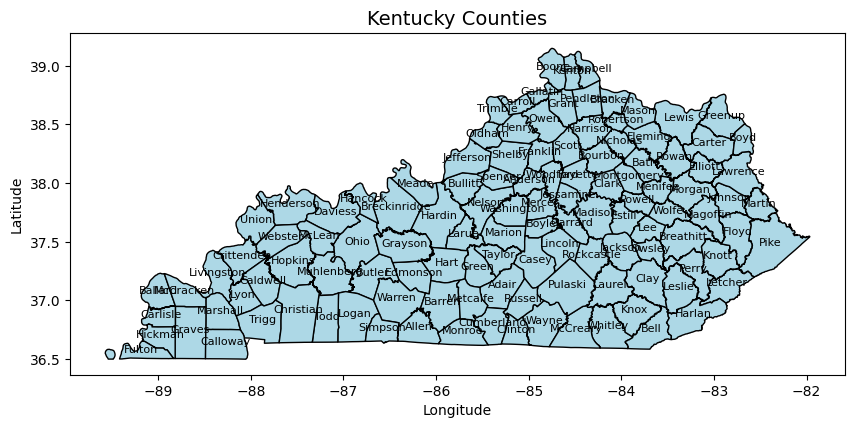

In [53]:
# Visualize the Kentucky county boundaries
fig, ax = plt.subplots(figsize=(10, 10))
result.plot(ax=ax, color='lightblue', edgecolor='black') # Use 'result' which has the correct geometry column

# Optional: Add labels for county names
for idx, row in result.iterrows():
    # Check if geometry is not None before accessing centroid
    if row['geometry']:
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, row['county_name'], fontsize=8, ha='center')

# Set title and labels
ax.set_title("Kentucky Counties", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

# Map Weather Stations to Counties using Spatial Join

In [54]:
# This cell replaces the original cell with ID 91a3bb5d
# It performs the spatial join to map weather stations to counties.

# Step 1: Get unique station locations from both precipitation and temperature data
stations_list_precip = 'data/ky_prec_with_gps.csv'
cols = ['STATION', 'LATITUDE', 'LONGITUDE']
dtypes = {'STATION': 'category', 'LATITUDE': 'float32', 'LONGITUDE': 'float32'}
stations_df_precip = pd.read_csv(stations_list_precip, dtype=dtypes, usecols=cols)
stations_df_precip_unique = stations_df_precip.drop_duplicates(subset='STATION')

stations_list_temp = 'data/ky_temperature.csv'
stations_df_temp = pd.read_csv(stations_list_temp, dtype=dtypes, usecols=cols)
stations_df_temp_unique = stations_df_temp.drop_duplicates(subset='STATION')

# Merge unique stations using an outer join to keep all stations
stations_merged = pd.merge(
    stations_df_precip_unique,
    stations_df_temp_unique,
    on=['STATION', 'LATITUDE', 'LONGITUDE'],
    how='outer'
).drop_duplicates(subset='STATION')

# Ensure stations_merged has valid LATITUDE and LONGITUDE
stations_merged = stations_merged.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Step 2: Convert stations DataFrame to a GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations_merged,
    geometry=gpd.points_from_xy(stations_merged.LONGITUDE, stations_merged.LATITUDE),
    crs="EPSG:4326"  # Assuming original coordinates are WGS84
)

# Step 3: Ensure Coordinate Reference Systems (CRS) match before spatial join
# Reproject stations_gdf to match the CRS of the 'result' GeoDataFrame (Kentucky counties)
stations_gdf = stations_gdf.to_crs(result.crs)

# Step 4: Perform the spatial join
# This finds which county polygon each station point falls within (or intersects)
joined_stations_counties = gpd.sjoin(stations_gdf, result, how="inner", predicate='intersects')

# Step 5: Create the final station-to-county lookup table
# Keep only necessary columns and rename for clarity
county_Weather_station_lookup = joined_stations_counties[['county_name', 'county_code', 'STATION']].rename(columns={
    'STATION': 'weather_station'
}).drop_duplicates(subset=['weather_station']) # Ensure one county per station

# Display the lookup table
print("Weather Station to County Lookup Table (Head):")
display(county_Weather_station_lookup.head())
print(f"Number of unique stations mapped to counties: {len(county_Weather_station_lookup)}")

Weather Station to County Lookup Table (Head):


,county_name,county_code,weather_station
2,Adair,001,US1KYAD0001
3,Adair,001,US1KYAD0003
4,Allen,003,US1KYAL0001
5,Allen,003,US1KYAL0003
6,Allen,003,US1KYAL0004


Number of unique stations mapped to counties: 800


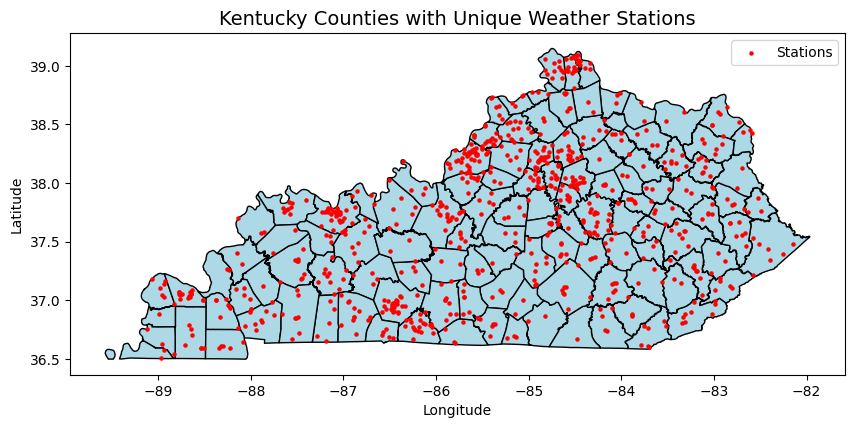

In [55]:
# Visualize the counties and the mapped weather stations
fig, ax = plt.subplots(figsize=(10, 10))
result.plot(ax=ax, color='lightblue', edgecolor='black') # Plot counties

# Plot stations (using stations_gdf defined in the previous cell)
stations_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Stations')

# Optional: Label station names (can be very cluttered)
# for idx, row in stations_gdf.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, row.STATION, fontsize=1, ha='left')

ax.set_title("Kentucky Counties with Unique Weather Stations", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

# Aggregate and Merge Weather Data by County

In [56]:
# This cell replaces the original cell with ID 34686d3b
# It aggregates precipitation and temperature data by county and date, then merges them.

# --- Precipitation Data Preparation ---
# Merge precipitation data with the county lookup table
weather_df_with_county = weather_df.merge(
    county_Weather_station_lookup,
    left_on='STATION',
    right_on='weather_station',
    how='left' # Keep all precip records initially
)

# Drop rows where a county could not be assigned
weather_df_with_county.dropna(subset=['county_name'], inplace=True)
weather_df_with_county['county_name'] = weather_df_with_county['county_name'].str.title() # Normalize case

# Calculate average PRCP per county per day
prcp_by_county = weather_df_with_county.groupby(['county_name', 'DATE'])['PRCP'].mean().reset_index()
prcp_by_county.rename(columns={'PRCP': 'MEAN_PRCP'}, inplace=True)

# --- Temperature Data Preparation ---
# Merge temperature data with the county lookup table
weather_T_with_county = weather_T.merge(
    county_Weather_station_lookup,
    left_on='STATION',
    right_on='weather_station',
    how='left' # Keep all temp records initially
)

# Drop rows where a county could not be assigned
weather_T_with_county.dropna(subset=['county_name'], inplace=True)
weather_T_with_county['county_name'] = weather_T_with_county['county_name'].str.title() # Normalize case

# Calculate average TMAX and TMIN per county per day
temp_by_county = weather_T_with_county.groupby(['county_name', 'DATE'])[['TMAX', 'TMIN']].mean().reset_index()

# --- Combine Weather Data ---
# Merge aggregated precipitation with aggregated temperature using an OUTER join
# This ensures all date/county combinations from both datasets are kept.
combined_weather = pd.merge(
    prcp_by_county,
    temp_by_county,
    on=['county_name', 'DATE'],
    how='outer'
)

# --- Handle Missing Values ---
# Strategy: Drop rows where TMAX or TMIN is missing after the outer join.
# This means we only keep days/counties where we have both precipitation AND temperature readings.
# Then, fill any remaining missing MEAN_PRCP with 0 (assuming no record means zero precipitation).
# Adjust this strategy if your analysis requires different handling (e.g., imputation, ffill/bfill).
print(f"Combined weather rows before dropping NaNs in Temp: {len(combined_weather)}")
combined_weather.dropna(subset=['TMAX', 'TMIN'], inplace=True)
print(f"Combined weather rows after dropping NaNs in Temp: {len(combined_weather)}")

# Fill remaining NaNs in MEAN_PRCP with 0
combined_weather['MEAN_PRCP'].fillna(0, inplace=True)

# --- Final Formatting ---
combined_weather.rename(columns={'county_name': 'County'}, inplace=True)
combined_weather['MEAN_PRCP'] = combined_weather['MEAN_PRCP'].round(1) # Optional: Round precip

# Display info and head of the final combined weather data
print("\nCombined Weather Data Info:")
display(combined_weather.info())
print("\nCombined Weather Data Head:")
display(combined_weather.head(10))

Combined weather rows before dropping NaNs in Temp: 952271
Combined weather rows after dropping NaNs in Temp: 634295

Combined Weather Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 634295 entries, 7216 to 952268
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   County     634295 non-null  object 
 1   DATE       634295 non-null  object 
 2   MEAN_PRCP  634295 non-null  float64
 3   TMAX       634295 non-null  float32
 4   TMIN       634295 non-null  float32
dtypes: float32(2), float64(1), object(2)
memory usage: 24.2+ MB


C:\Users\efaris\AppData\Local\Temp\ipykernel_1400\3283160474.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_weather['MEAN_PRCP'].fillna(0, inplace=True)


None


Combined Weather Data Head:


,County,DATE,MEAN_PRCP,TMAX,TMIN
7216,Allen,1998-01-01,129.0,45.0,15.0
7217,Allen,1998-01-02,0.0,54.0,29.0
7218,Allen,1998-01-03,0.0,64.0,50.0
7219,Allen,1998-01-04,0.0,67.0,51.0
7220,Allen,1998-01-05,659.0,63.0,55.0
7221,Allen,1998-01-06,80.0,68.0,58.0
7222,Allen,1998-01-07,4290.0,65.0,60.0
7223,Allen,1998-01-08,200.0,61.0,49.0
7224,Allen,1998-01-09,810.0,49.0,35.0
7225,Allen,1998-01-10,0.0,41.0,34.0


# Map Disaster Data to Combined Weather Data

In [57]:
# This cell replaces the original cell with ID 2b591437
# It merges the combined weather data with the merged FEMA disaster data.

# Normalize the incident date to match weather DATE format (if not already done)
incident_df['incident_date'] = pd.to_datetime(incident_df['incidentBeginDate']).dt.date

# Normalize county names in both DataFrames to ensure proper matching (Title Case)
combined_weather['County'] = combined_weather['County'].str.strip().str.title()
incident_df['normalized_county'] = incident_df['normalized_county'].str.strip().str.title()

# Merge combined weather data with the incident data
# Use a left join to keep all weather records and add disaster info where dates/counties match
disaster_with_weather = pd.merge(
    combined_weather, # Left DataFrame (Weather)
    incident_df,      # Right DataFrame (Disasters)
    how='left',
    left_on=['County', 'DATE'],                   # Keys from left DataFrame
    right_on=['normalized_county', 'incident_date'] # Keys from right DataFrame
)

# Display info and head of the merged dataset
print("Disaster Data Merged with Weather Info:")
display(disaster_with_weather.info())
print("\nDisaster Data Merged with Weather Head:")
display(disaster_with_weather.head(10))

Disaster Data Merged with Weather Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640547 entries, 0 to 640546
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   County             640547 non-null  object             
 1   DATE               640547 non-null  object             
 2   MEAN_PRCP          640547 non-null  float64            
 3   TMAX               640547 non-null  float32            
 4   TMIN               640547 non-null  float32            
 5   disasterNumber     6714 non-null    object             
 6   normalized_county  6714 non-null    object             
 7   countyCode         6714 non-null    category           
 8   projectSize        6714 non-null    category           
 9   projectAmount      6714 non-null    float32            
 10  incidentBeginDate  6714 non-null    datetime64[ns, UTC]
 11  incident_date      6714 non-null    object         

None


Disaster Data Merged with Weather Head:


,County,DATE,MEAN_PRCP,TMAX,TMIN,disasterNumber,normalized_county,countyCode,projectSize,projectAmount,incidentBeginDate,incident_date
0,Allen,1998-01-01,129.0,45.0,15.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,Allen,1998-01-02,0.0,54.0,29.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,Allen,1998-01-03,0.0,64.0,50.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,Allen,1998-01-04,0.0,67.0,51.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,Allen,1998-01-05,659.0,63.0,55.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
5,Allen,1998-01-06,80.0,68.0,58.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
6,Allen,1998-01-07,4290.0,65.0,60.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
7,Allen,1998-01-08,200.0,61.0,49.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
8,Allen,1998-01-09,810.0,49.0,35.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
9,Allen,1998-01-10,0.0,41.0,34.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN


# Compiling training data

In [58]:
# This cell replaces the original cell with ID ab2b2554
# It aggregates project amounts by day/county and performs final filtering.

# Fill NaN project amounts (days/counties with weather but no disaster project) with 0.0
disaster_with_weather['projectAmount'] = disaster_with_weather['projectAmount'].fillna(0.0)

# Group by County, Date, and weather features. Sum project amounts for that day/county.
# This handles cases where multiple projects might occur in the same county on the same day.
training_data = disaster_with_weather.groupby(
    ['County', 'DATE', 'MEAN_PRCP', 'TMAX', 'TMIN']
)['projectAmount'].sum().reset_index()

# Optional Filtering: Remove rows where precipitation is 0 but projectAmount > 0
# This was in the original code; keep or remove based on analysis needs.
# It assumes non-zero project amounts should only occur when there's non-zero precipitation.
print(f"Rows before filtering (PRCP=0, Amount>0): {len(training_data)}")
training_data = training_data[
    ~((training_data['MEAN_PRCP'] == 0.0) & (training_data['projectAmount'] > 0.0))
]
print(f"Rows after filtering: {len(training_data)}")

# Display info and head of the final training data structure
print("\nFinal Training Data Info:")
display(training_data.info())
print("\nFinal Training Data Head:")
display(training_data.head(10))

Rows before filtering (PRCP=0, Amount>0): 634295
Rows after filtering: 634155

Final Training Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 634155 entries, 0 to 634294
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   County         634155 non-null  object 
 1   DATE           634155 non-null  object 
 2   MEAN_PRCP      634155 non-null  float64
 3   TMAX           634155 non-null  float32
 4   TMIN           634155 non-null  float32
 5   projectAmount  634155 non-null  float32
dtypes: float32(3), float64(1), object(2)
memory usage: 26.6+ MB


None


Final Training Data Head:


,County,DATE,MEAN_PRCP,TMAX,TMIN,projectAmount
0,Allen,1998-01-01,129.0,45.0,15.0,0.0
1,Allen,1998-01-02,0.0,54.0,29.0,0.0
2,Allen,1998-01-03,0.0,64.0,50.0,0.0
3,Allen,1998-01-04,0.0,67.0,51.0,0.0
4,Allen,1998-01-05,659.0,63.0,55.0,0.0
5,Allen,1998-01-06,80.0,68.0,58.0,0.0
6,Allen,1998-01-07,4290.0,65.0,60.0,0.0
7,Allen,1998-01-08,200.0,61.0,49.0,0.0
8,Allen,1998-01-09,810.0,49.0,35.0,0.0
9,Allen,1998-01-10,0.0,41.0,34.0,0.0


In [59]:
# Aggregate By County and Day
# prcp_by_county = weather_df_with_county.groupby(['COUNTY','DATE'])['PRCP'].mean().reset_index()
# prcp_by_county.rename(columns={'PRCP': 'MEAN_PRCP'}, inplace=True)

# prcp_by_county[prcp_by_county['MEAN_PRCP'].isnull()]

# Preprocessing

In [62]:
# display(Training_output.info())

window = 7
decay_rate=0.2

def rolling_weighted_sum(group, decay):
    weights = np.exp(-decay * np.arange(window)[::-1])
    group = group.copy()
    group['WC_MEAN_PRCP'] = (
        group['MEAN_PRCP']
        .rolling(window, min_periods=1)
        .apply(lambda x: np.dot(x[::-1], weights[-len(x):]), raw=True).astype(np.float32)
    )
    return group

Training_output = training_data.groupby('County', group_keys=False).apply(rolling_weighted_sum, decay=decay_rate)

display(Training_output.info())

X = Training_output.drop(columns=['projectAmount', 'DATE'])
# y = Training_output['projectAmount']

enc = OrdinalEncoder()
enc.fit(X[['County']])
X['County'] = enc.transform(X[['County']])

scaler_X = MinMaxScaler()
X[['MEAN_PRCP', 'WC_MEAN_PRCP']] = scaler_X.fit_transform(X[['MEAN_PRCP', 'WC_MEAN_PRCP']])

binarizer_y = Binarizer(threshold=0.0)
y_binary = binarizer_y.fit_transform(Training_output[['projectAmount']])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Index: 634155 entries, 0 to 634294
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   County         634155 non-null  object 
 1   DATE           634155 non-null  object 
 2   MEAN_PRCP      634155 non-null  float64
 3   TMAX           634155 non-null  float32
 4   TMIN           634155 non-null  float32
 5   projectAmount  634155 non-null  float32
 6   WC_MEAN_PRCP   634155 non-null  float32
dtypes: float32(4), float64(1), object(2)
memory usage: 29.0+ MB


C:\Users\efaris\AppData\Local\Temp\ipykernel_1400\182132824.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Training_output = training_data.groupby('County', group_keys=False).apply(rolling_weighted_sum, decay=decay_rate)


None

# Model Training

## Logistic Regressions

In [67]:
log_reg_model = LogisticRegression(random_state=42)

log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred))
display(recall_score(y_test, y_pred))
display(precision_score(y_test, y_pred))

unique, counts = np.unique(y_pred, return_counts=True)
display(counts)

C:\Users\efaris\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9994428295846978

0.0

0.0

C:\Users\efaris\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

array([190247])

## Gradient Boosting

In [68]:
# GBC_model = GradientBoostingClassifier(random_state=42)

# GBC_model.fit(X_train, y_train)

# y_pred = GBC_model.predict(X_test)
# display(accuracy_score(y_test, y_pred))
# display(f1_score(y_test, y_pred))
# display(recall_score(y_test, y_pred))
# display(precision_score(y_test, y_pred))

# unique, counts = np.unique(y_pred, return_counts=True)
# display(counts)

# XGBoost

In [69]:
xgb_clf = xgb.XGBClassifier(n_splits=10, n_repeats=3, random_state=42)

xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

y_pred = xgb_clf.predict(X_test)
display(accuracy_score(y_test, y_pred))
display(f1_score(y_test, y_pred))
display(recall_score(y_test, y_pred))
display(precision_score(y_test, y_pred))

unique, counts = np.unique(y_pred, return_counts=True)
display(counts)

C:\Users\efaris\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:59:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_repeats", "n_splits" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-logloss:0.00464
[1]	validation_0-logloss:0.00450
[2]	validation_0-logloss:0.00437
[3]	validation_0-logloss:0.00426
[4]	validation_0-logloss:0.00422
[5]	validation_0-logloss:0.00418
[6]	validation_0-logloss:0.00415
[7]	validation_0-logloss:0.00413
[8]	validation_0-logloss:0.00411
[9]	validation_0-logloss:0.00410
[10]	validation_0-logloss:0.00409
[11]	validation_0-logloss:0.00408
[12]	validation_0-logloss:0.00408
[13]	validation_0-logloss:0.00407
[14]	validation_0-logloss:0.00408
[15]	validation_0-logloss:0.00408
[16]	validation_0-logloss:0.00408
[17]	validation_0-logloss:0.00410
[18]	validation_0-logloss:0.00410
[19]	validation_0-logloss:0.00410
[20]	validation_0-logloss:0.00411
[21]	validation_0-logloss:0.00411
[22]	validation_0-logloss:0.00412
[23]	validation_0-logloss:0.00412
[24]	validation_0-logloss:0.00413
[25]	validation_0-logloss:0.00413
[26]	validation_0-logloss:0.00413
[27]	validation_0-logloss:0.00413
[28]	validation_0-logloss:0.00414
[29]	validation_0-loglos

0.9994323169353525

0.0

0.0

0.0

array([190245,      2])

# Visualizations/EDA

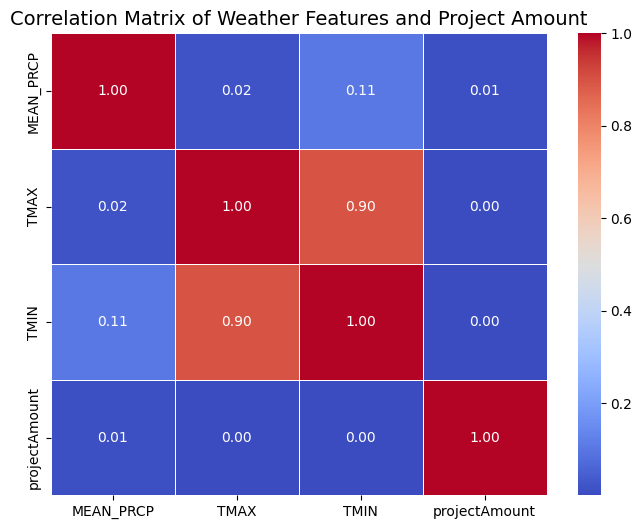


Correlation Matrix:


,MEAN_PRCP,TMAX,TMIN,projectAmount
MEAN_PRCP,1.000000,0.017841,0.105847,0.011717
TMAX,0.017841,1.000000,0.897294,0.000606
TMIN,0.105847,0.897294,1.000000,0.002837
projectAmount,0.011717,0.000606,0.002837,1.000000


In [ ]:
# Select only the numerical columns for correlation analysis
numerical_cols = ['MEAN_PRCP', 'TMAX', 'TMIN', 'projectAmount']
correlation_data = training_data[numerical_cols]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(correlation_matrix,
            annot=True,      # Show the correlation values on the heatmap
            cmap='coolwarm', # Color map (e.g., coolwarm, seismic, viridis)
            fmt=".2f",       # Format the annotation values to 2 decimal places
            linewidths=.5)   # Add lines between cells

# Add a title
plt.title('Correlation Matrix of Weather Features and Project Amount', fontsize=14)

# Show the plot
plt.show()

# Optional: Display the correlation matrix values
print("\nCorrelation Matrix:")
display(correlation_matrix)

In [ ]:
df = pd.read_csv("data/ky_prec_with_gps.csv")

# Ensure data types are correct
df['PRCP'] = pd.to_numeric(df['PRCP'], errors='coerce')
df = df.dropna(subset=['LATITUDE', 'LONGITUDE', 'PRCP'])

# Group by station to get mean precipitation per station
station_data = df.groupby(['STATION', 'LATITUDE', 'LONGITUDE']).agg({'PRCP': 'mean'}).reset_index()

# Normalize precipitation
scaler = MinMaxScaler()
station_data['PRCP_scaled'] = scaler.fit_transform(station_data[['PRCP']])

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter
(
    station_data['LONGITUDE'],
    station_data['LATITUDE'],
    c=station_data['PRCP'],
    s=station_data['PRCP_scaled'] * 200 + 10,  
    cmap='Blues',
    alpha=0.6,
    edgecolors='k'
)

plt.colorbar(scatter, label='Average Precipitation')
plt.title("Weather Stations: Precipitation vs. Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (3918221687.py, line 20)

In [ ]:
prcp_df = pd.read_csv("sample_data/ky_prec_with_gps.csv")
prcp_df['PRCP'] = pd.to_numeric(prcp_df['PRCP'], errors='coerce')
prcp_df = prcp_df.dropna(subset=['LATITUDE', 'LONGITUDE', 'PRCP'])

# Average precipitation per station
prcp_grouped = prcp_df.groupby(['STATION', 'LATITUDE', 'LONGITUDE']).agg({'PRCP': 'mean'}).reset_index()

# Normalize precip like above graph
prcp_scaler = MinMaxScaler()
prcp_grouped['PRCP_scaled'] = prcp_scaler.fit_transform(prcp_grouped[['PRCP']])

# Load temperature data
temp_df = pd.read_csv("sample_data/ky_temperature.csv")
temp_df[['TMAX', 'TMIN']] = temp_df[['TMAX', 'TMIN']].apply(pd.to_numeric, errors='coerce')
temp_df = temp_df.dropna(subset=['LATITUDE', 'LONGITUDE', 'TMAX', 'TMIN'])

# Average temperature per station (still in Celsius)
temp_df.loc[:, 'TAVG'] = (temp_df['TMAX'] + temp_df['TMIN']) / 2
temp_grouped = temp_df.groupby(['STATION', 'LATITUDE', 'LONGITUDE']).agg({'TAVG': 'mean'}).reset_index()

# Merge both datasets on station coordinates
merged = pd.merge(prcp_grouped, temp_grouped, on=['STATION', 'LATITUDE', 'LONGITUDE'])

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    merged['LONGITUDE'],
    merged['LATITUDE'],
    s=merged['PRCP_scaled'] * 300 + 20,  # Dot size: precipitation
    c=merged['TAVG'],                   # Dot color: temperature
    cmap='OrRd',                        # Light to dark orange-red
    alpha=0.8,
    edgecolors='k'
)

plt.colorbar(scatter, label='Average Temperature (°F)')
plt.title("KY Weather Stations: Precipitation (Size) & Temperature (Color, °F)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()